<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Double Machine Learning: Use Cases and Examples

Double Machine Learning (DML) is an algorithm that applies arbitrary machine learning methods
to fit the treatment and response, then uses a linear model to predict the response residuals
from the treatment residuals.

The EconML SDK implements the following DML classes:
* LinearDML: suitable for estimating heterogeneous treatment effects.
* SparseLinearDML: suitable for the case when $W$ is high dimensional vector and both the first stage and second stage estimate are linear.

In ths notebook, we show the performance of the DML on both synthetic data and observational data.

**Notebook contents:**

1. Example usage with single continuous treatment synthetic data
2. Example usage with single binary treatment synthetic data
3. Example usage with multiple continuous treatment synthetic data
4. Example usage with single continuous treatment observational data
5. Example usage with multiple continuous treatment, multiple outcome observational data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import econml

In [3]:
## Ignore warnings
import warnings
warnings.filterwarnings('ignore') 

In [52]:
# Main imports
from econml.dml import DML, LinearDML, SparseLinearDML, NonParamDML
from econml.metalearners import XLearner, TLearner, SLearner, DomainAdaptationLearner
from econml.drlearner import DRLearner

import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

## 2. Example Usage with Single Binary Treatment Synthetic Data

### 2.1. DGP 
We use the following DGP:

\begin{align}
T \sim & \text{Bernoulli}\left(f(W)\right), &\; f(W)=\sigma(\langle W, \beta\rangle + \eta), \;\eta \sim \text{Uniform}(-1, 1)\\
Y = & T\cdot \theta(X) + \langle W, \gamma\rangle + \epsilon, & \; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim & \text{Normal}(0,\, I_{n_w}) & \\
X \sim & \text{Uniform}(0,\, 1)^{n_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders, $\beta, \gamma$ have high sparsity and $\sigma$ is the sigmoid function.

For this DGP, 
\begin{align}
\theta(x) = \exp( 2\cdot x_1 ).
\end{align}

In [78]:
# Treatment effect function
def exp_te(x):
    return np.exp(2 * x[:, 0])# DGP constants
def exp_te(x):
    return 4*x[:, 0]

np.random.seed(123)
n = 3000
support_size = 5
n_x = 10
# Outcome support
support_Y = np.random.choice(range(n_x), size=support_size, replace=False)
coefs_Y = np.random.uniform(0, 1, size=support_size)
epsilon_sample = lambda n:np.random.uniform(-1, 1, size=n)
# Treatment support
support_T = support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
eta_sample = lambda n: np.random.uniform(-1, 1, size=n) 

# Generate controls, covariates, treatments and outcomes
X = np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
TE = exp_te(X)
# Define treatment
log_odds = np.dot(X[:, support_T], coefs_T) + eta_sample(n)
T_sigmoid = 1/(1 + np.exp(-log_odds))
T = np.array([np.random.binomial(1, p) for p in T_sigmoid])
# Define the outcome
Y = TE * T + np.dot(X[:, support_Y], coefs_Y) + epsilon_sample(n)

# get testing data
X_test = np.random.uniform(0, 1, size=(n, n_x))
X_test[:, 0] = np.linspace(0, 1, n)

### 2.2. Train Estimator

In [79]:
reg = lambda: RandomForestRegressor(min_samples_leaf=10)
clf = lambda: RandomForestClassifier(min_samples_leaf=10)

In [80]:
X_train, X_val, T_train, T_val, Y_train, Y_val = train_test_split(X, T, Y, test_size=.4)

In [81]:
est = LinearDML(model_y=reg(), model_t=clf(), discrete_treatment=True,
                linear_first_stages=False, n_splits=6)
est.fit(Y_train, T_train, X=X_train)

In [82]:
est2 = SparseLinearDML(model_y=reg(), model_t=clf(), discrete_treatment=True,
                       featurizer=PolynomialFeatures(degree=2),
                       linear_first_stages=False, n_splits=6)
est2.fit(Y_train, T_train, X=X_train)

In [83]:
est3 = XLearner(models=reg(), cate_models=reg(), propensity_model=clf())
est3.fit(Y_train, T_train, X=X_train)

In [84]:
est4 = DomainAdaptationLearner(models=reg(), final_models=reg(), propensity_model=clf())
est4.fit(Y_train, T_train, X=X_train)

In [85]:
est5 = SLearner(overall_model=reg())
est5.fit(Y_train, T_train, X=X_train)

In [86]:
est6 = TLearner(models=reg())
est6.fit(Y_train, T_train, X=X_train)

In [87]:
est7 = DRLearner(model_propensity=clf(), model_regression=reg(), n_splits=6)
est7.fit(Y_train, T_train, X=X_train)

In [88]:
est8 = NonParamDML(model_y=reg(), model_t=clf(), model_final=reg(), discrete_treatment=True, n_splits=6)
est8.fit(Y_train, T_train, X=X_train)

In [89]:
est9 = DML(model_y=reg(), model_t=clf(), model_final=LassoCV(), discrete_treatment=True,
           featurizer=PolynomialFeatures(degree=3),
           linear_first_stages=False, n_splits=6)
est9.fit(Y_train, T_train, X=X_train)

In [90]:
from econml.score import RScorer

scorer = RScorer(model_y=reg(), model_t=clf(),
                 discrete_treatment=True, n_splits=3)
scorer.fit(Y_val, T_val, X=X_val)

In [91]:
models = [(est, 'ldml'), (est2, 'sldml2d'), (est3, 'xlearner'),
          (est4, 'dalearner'), (est5, 'slearner'), (est6, 'tlearner'),
          (est7, 'drlearner'), (est8, 'rlearner'), (est9, 'dml3dlasso')]

In [92]:
rscore = [scorer.score(mdl) for mdl, _ in models]

In [93]:
expected_te = exp_te(X_val)

In [94]:
rootpehe = [np.sqrt(np.mean((expected_te.flatten() - mdl.effect(X_val).flatten())**2)) for mdl, _ in models]

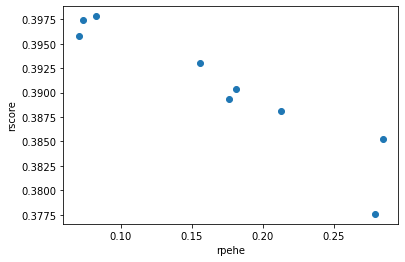

In [95]:
plt.scatter(rootpehe, rscore)
plt.xlabel('rpehe')
plt.ylabel('rscore')
plt.show()

### 2.3. Performance Visualization

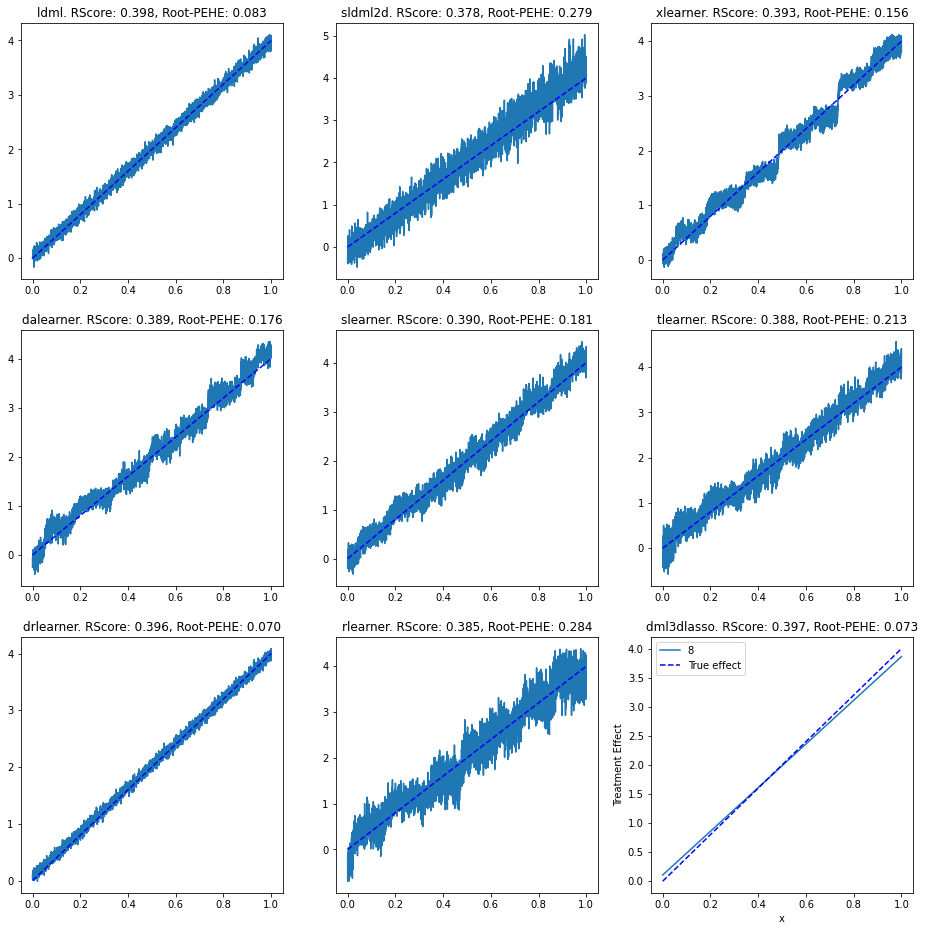

In [96]:
plt.figure(figsize=(16, 16))
rows = int(np.ceil(len(models) / 3))
for it, (mdl, name) in enumerate(models):
    plt.subplot(rows, 3, it + 1)
    plt.title('{}. RScore: {:.3f}, Root-PEHE: {:.3f}'.format(name, rscore[it], rootpehe[it]))
    plt.plot(X_test[:, 0], mdl.effect(X_test), label='{}'.format(it))
    plt.plot(X_test[:, 0], exp_te(X_test), 'b--', label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()